#Let's make fake galaxies!
Let's say you want to test your spectral fitting model's measurements of mass-weighted age... First, generate a CSP spectrum with a known SFH (and therefore, a known MWA). I'm using BC03. We can read in that spectrum, and fill an entire IFU with that spectrum, subject to some noise. We then feed that IFU into our spectral fitting model, and see how well the inference works at various levels of noise. 

`zaphod` giveth confidence, and `zaphod` taketh confidence away.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy import units as u

Start by reading in a SFH, the resulting log-wavelength & spectrum, and the instrument's spectral covariance matrix...

In [34]:
from find_pcs import *
import find_pcs
reload(find_pcs)

import cPickle as pkl

In [35]:
pca = pkl.load(open('../../stellarmass_pca/pca.pkl', 'r'))

In [38]:
sfh_spec = pca.trn_spectra[1]
sfh_logl = pca.logl

spec_cov = np.load('bc03/manga_cov_for_model.npy')

In [40]:
param = 'D4000'
param_real = pca.metadata[param][1]
print param, param_real

D4000 1.62583


In [27]:
import fake
reload(fake)

<module 'fake' from 'fake.py'>

Instantiate a `FakeIFU` object, with the parameters you're trying to fit for. Also note that we've supplied a spectral covariance matrix (but you could give a constant or a 1d array, and a multivariate---but non-covariate---matrix would be constructed for you). Also, it's almost certain that you don't know your actual spectral covariance, but how bad it really is depends on how careful your spectrophotometric calibration is. This is a can of worms.

In [41]:
fake_ifu = fake.FakeIFU.SingleSFH(
    logl=sfh_logl, dlogl=1.0e-4, spec=sfh_spec, 
    true_params=[Mstar_real], param_names=['MWA'],
    F_max=1.0e4, K=spec_cov)

Now make an artificial cube, with the given covariate noise, all built around a single SFH, but with a variety of amplitudes

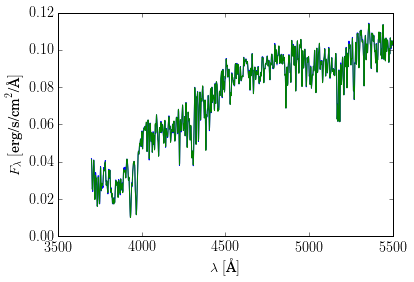

In [42]:
cube = fake_ifu.make_datacube()
plt.plot(10.**sfh_logl, cube[:, 37, 37])
plt.plot(10.**sfh_logl, fake_ifu.true_spectra[:, 37, 37])
plt.xlabel(r'$\lambda~[\textrm{\AA}]$')
plt.ylabel(r'$F_{\lambda}~[\textrm{erg/s/cm}^2\textrm{/\AA}]$')
plt.show()

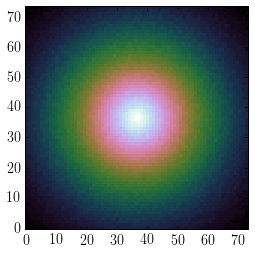

In [43]:
dlogl = 1.0e-4
l_l = 10.**(fake_ifu.logl - dlogl/2.)
l_u = 10.**(fake_ifu.logl + dlogl/2.)
dl = l_u - l_l
plt.imshow(
    (cube * dl[..., None, None]).sum(axis=0),
    aspect='equal')

Look at all those Balmer lines!

#Now let's test my PCA SP fitter

In [44]:
import sys
if '../../stellarmass_pca/' not in sys.path:
    sys.path.append('../../stellarmass_pca/')
print sys.path[-1]
# this is where all my SP fitting code lives

../../stellarmass_pca/


In [45]:
from cov_obs import *
import cPickle as pkl
from astropy.cosmology import WMAP9 as cosmo

Here's some prep for my spectral fits. Ignore this.

In [46]:
cov = Cov_Obs(
    cov=fake_ifu.K, lllim=10.**sfh_logl[0],
    dlogl=1.0e-4, nobj=0, SB_r_mean=0.)

In [47]:
pca_res = find_pcs.Test_PCA_Result(
    pca=pca, K_obs=cov, cosmo=cosmo, fake_ifu=fake_ifu,
    objname = 'FAKE')

In [48]:
param_fit = pca_res.pca.param_pct_map(
    param, pca_res.w, [50.])[0, ...]

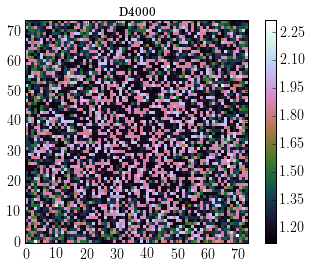

In [50]:
plt.imshow(param_fit, aspect='equal')
plt.colorbar()
plt.title('D4000')
plt.show()

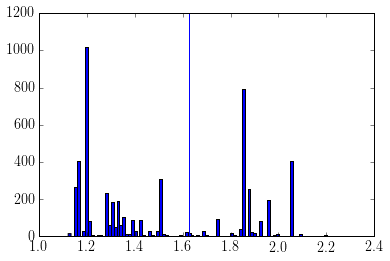

In [49]:
plt.hist(param_fit.flatten(), 100)
plt.axvline(param_real)